In [1]:
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
fp = r"L2_data/Europe_borders_epsg3035.shp"
data = gpd.read_file(fp)

In [12]:
hki_lon = 24.9417
hki_lat = 60.1666

helsinki = gpd.GeoDataFrame(
    [[Point(hki_lon, hki_lat)]], 
    geometry='geometry', 
    crs={'init': 'epsg:4326'}, 
    columns=['geometry']
)

helsinki

,geometry
0,POINT (24.94170 60.16660)


In [16]:
aeqd = CRS(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=hki_lat, lon_0=hki_lon)
helsinki = helsinki.to_crs(crs=aeqd)

print(helsinki)
print(f'CRS: {helsinki.crs}')

                  geometry
0  POINT (0.00000 0.00000)
CRS: +proj=aeqd +ellps=WGS84 +datum=WGS84 +lat_0=60.1666 +lon_0=24.9417 +type=crs


In [17]:
europe_borders_aeqd = data.copy()
europe_borders_aeqd = europe_borders_aeqd.to_crs(crs=aeqd)
europe_borders_aeqd.head()

,TZID,geometry
0,Europe/Berlin,"POLYGON ((-1057542.597 -493724.802, -1058052.5..."
1,Europe/Berlin,"POLYGON ((-1216418.435 -1243831.635, -1216378...."
2,Europe/Berlin,"POLYGON ((-1194521.639 -571726.459, -1194674.9..."
3,Europe/Berlin,"POLYGON ((-1185933.276 -571780.053, -1186040.7..."
4,Europe/Berlin,"POLYGON ((-1182416.220 -569097.571, -1183274.4..."


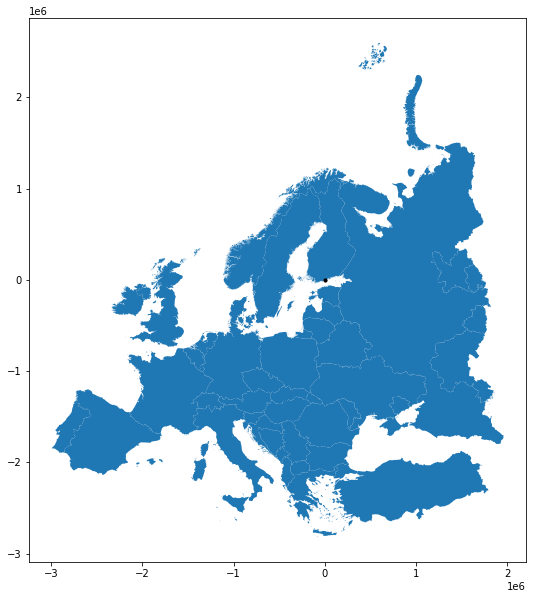

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
europe_borders_aeqd.plot(ax=ax)
helsinki.plot(ax=ax, color='black', markersize=10)

In [19]:
europe_borders_aeqd['centroid'] = europe_borders_aeqd.centroid
europe_borders_aeqd.head()

,TZID,geometry,centroid
0,Europe/Berlin,"POLYGON ((-1057542.597 -493724.802, -1058052.5...",POINT (-1057718.135 -492420.566)
1,Europe/Berlin,"POLYGON ((-1216418.435 -1243831.635, -1216378....",POINT (-1218235.217 -1242668.590)
2,Europe/Berlin,"POLYGON ((-1194521.639 -571726.459, -1194674.9...",POINT (-1194210.789 -568987.153)
3,Europe/Berlin,"POLYGON ((-1185933.276 -571780.053, -1186040.7...",POINT (-1185320.606 -571340.313)
4,Europe/Berlin,"POLYGON ((-1182416.220 -569097.571, -1183274.4...",POINT (-1182191.163 -567293.764)


In [20]:
def calculate_distance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
       A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
       A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
       A name of the target column where the result will be stored.

    Returns
    -------

    Distance in kilometers that will be stored in 'target_col'.
    """

    # Calculate the distances
    dist = row[src_col].distance(dest_geom)

    # Convert into kilometers
    dist_km = dist / 1000

    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

In [23]:
helsinki_geom = helsinki.loc[0, 'geometry']
print(helsinki_geom)

POINT (0 0)


In [24]:
europe_borders_aeqd = europe_borders_aeqd.apply(
    calculate_distance, 
    dest_geom=helsinki_geom, 
    src_col='centroid', 
    target_col='dist_to_Hki', 
    axis=1
)

In [25]:
europe_borders_aeqd

,TZID,geometry,centroid,dist_to_Hki
0,Europe/Berlin,"POLYGON ((-1057542.597 -493724.802, -1058052.5...",POINT (-1057718.135423443 -492420.5658204998),1166.724332
1,Europe/Berlin,"POLYGON ((-1216418.435 -1243831.635, -1216378....",POINT (-1218235.216971495 -1242668.589667923),1740.207536
2,Europe/Berlin,"POLYGON ((-1194521.639 -571726.459, -1194674.9...",POINT (-1194210.78929945 -568987.1532380251),1322.832487
3,Europe/Berlin,"POLYGON ((-1185933.276 -571780.053, -1186040.7...",POINT (-1185320.605845876 -571340.3134827728),1315.832319
4,Europe/Berlin,"POLYGON ((-1182416.220 -569097.571, -1183274.4...",POINT (-1182191.163363772 -567293.763983083),1311.258236
...,...,...,...,...
3627,Europe/Stockholm,"POLYGON ((-350023.571 -58612.454, -350681.806 ...",POINT (-350796.2448285696 -58633.71720893512),355.662647
3628,Europe/Stockholm,"POLYGON ((-344964.380 -57681.275, -345021.427 ...",POINT (-343929.6315293383 -57404.08177537643),348.687281
3629,Europe/Stockholm,"POLYGON ((-359118.196 -61891.189, -359403.465 ...",POINT (-356622.6500510125 -55155.42134938933),360.862626
3630,Europe/Minsk,"POLYGON ((352360.118 -952983.492, 352050.244 -...",POINT (205532.3957203254 -734149.0356800212),762.376792


In [26]:
max_dist = europe_borders_aeqd['dist_to_Hki'].max()
mean_dist = europe_borders_aeqd['dist_to_Hki'].mean()

print("Maximum distance to Helsinki is %.0f km, and the mean distance is %.0f km." % (max_dist, mean_dist))

Maximum distance to Helsinki is 3470 km, and the mean distance is 1177 km.
